In [ ]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from scipy.stats import ttest_rel, wilcoxon, sem
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
%matplotlib inline

In [109]:
def add_prefix_to_index(df, prefix):
    df = df.copy()  # Avoid modifying the original DataFrame
    df.index = [f"{prefix}_{idx}" for idx in df.index]
    return df
index_adj_combined_dict = {}

In [110]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    barcodes = add_prefix_to_index(barcodes, mouse)
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False, dummy_data=False)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['area_is_main']= fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, IT_only=True, shuffled=False)
    new_dict['max_counts'] = barcodes.max(axis=1)
    combined_dict[mouse] = new_dict


In [111]:
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
all_mice = {}
for i, key in enumerate(analysis_names):
    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    # all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns], combined_dict['FIAA55.4d'][key][common_columns]], ignore_index=False)
    

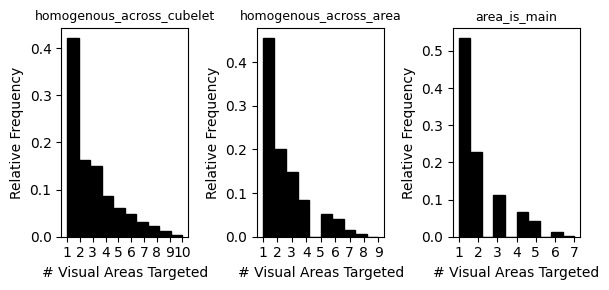

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3), constrained_layout=True)
for number_plot, key in enumerate(analysis_names):
    visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
    vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]
    #data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()
    data = vis_proj[vis_adj].astype(bool).sum(axis=1)
     
    axes[number_plot].hist(data, bins=10, weights=np.ones_like(data) / len(data), color='black',edgecolor='black')
    axes[number_plot].set_xticks(np.arange(min(data), max(data) + 1, 1))
    axes[number_plot].set_xlabel('# Visual Areas Targeted')
    axes[number_plot].set_ylabel('Relative Frequency')
    axes[number_plot].set_title(key, size=9)
plt.tight_layout()
plt.show()

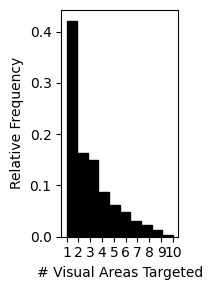

In [120]:
key='homogenous_across_cubelet'
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]
#data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()
data = vis_proj[vis_adj].astype(bool).sum(axis=1)
fig, ax = plt.subplots(figsize=(2, 3))  
ax.hist(data, bins=10, weights=np.ones_like(data) / len(data), color='black',edgecolor='black')
ax.set_xticks(np.arange(min(data), max(data) + 1, 1))
ax.set_xlabel('# Visual Areas Targeted')
ax.set_ylabel('Relative Frequency')
plt.tight_layout()
plt.show()
max_counts_list = [data["max_counts"] for data in combined_dict.values()]

# Concatenate all 'max_counts' dataframes
concatenated_max_counts = pd.concat(max_counts_list, ignore_index=False)
max_counts = concatenated_max_counts.loc[vis_proj[vis_adj].index]

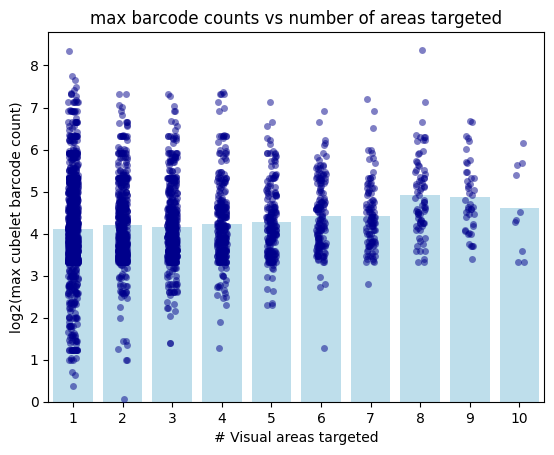

In [121]:
df = pd.DataFrame({"x": data, "y": np.log2(max_counts)})
sb.barplot(x="x", y="y", data=df, alpha=0.6, color="skyblue", ci=None)

# Overlay individual points
sb.stripplot(x="x", y="y", data=df, color="darkblue", alpha=0.5, jitter=True)
plt.title("max barcode counts vs number of areas targeted")
plt.xlabel("# Visual areas targeted")
plt.ylabel("log2(max cubelet barcode count)")
plt.show()


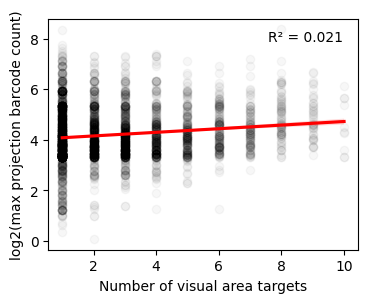

In [122]:
df = pd.DataFrame({"x": data, "y": np.log2(max_counts)})
plt.figure(figsize=(4, 3))

sb.regplot(
    x="x", y="y", data=df,
    scatter_kws={'alpha': 0.03, 'color': 'black'},  # Scatter points in blue
    line_kws={'color': 'red'},  # Regression line in black
)

# Extract x and y data
x = df['x'].values.reshape(-1, 1)  # Reshape for sklearn
y = df['y'].values

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Calculate R-squared
r_squared = model.score(x, y)

# Add R-squared to the plot
plt.text(
    0.95, 0.95,  # x and y positions in axes coordinates
    f"R² = {r_squared:.3f}",
    ha='right', va='top',  # Align text to the top-right
    transform=plt.gca().transAxes,  # Use axes coordinates for placement
    fontsize=10,  # Font size of the text
)
plt.ylabel('log2(max projection barcode count)')
plt.xlabel('Number of visual area targets')
# Show the plot
plt.show()

In [124]:
key = 'homogenous_across_cubelet'
freq_df = pd.DataFrame(index=mice, columns=visual_areas)
for mouse in mice:
    df_to_look = combined_dict[mouse][key].astype(bool).astype(int)
    for area in visual_areas:
        freq_df.loc[mouse, area] = df_to_look[area].mean()


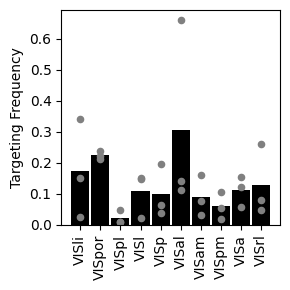

In [130]:
area_means = freq_df.mean()

# Plot
plt.figure(figsize=(3, 3))

# Create bar plot for mean values
sb.barplot(x=area_means.index, y=area_means.values, color='black', ci=None, width=0.9, zorder=1)

# Overlay individual data points
for i, area in enumerate(freq_df.columns):
    for val in freq_df[area]:
        plt.scatter(i, val, color='grey', s=20, alpha=1, zorder=2)

# Customize plot
plt.ylabel('Targeting Frequency')
plt.xticks(rotation=90)
plt.tight_layout()

# Show plot
plt.show()

In [24]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
structure_tree = mcc.get_structure_tree()
cond_freq_dict = {}
for i, key in enumerate(analysis_names):
    #analysis_dict = {}
    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    # all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col == 'Contra':
            common_cols_cortex.append(col)
        if col != 'Contra':
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    #visual_areas = ['VISpor',  'VISli', 'VISpl','VISal', 'VISl', 'VISrl', 'VISp', 'VISa', 'VISam', 'VISpm']
    vis_adj =[vis for vis in visual_areas if vis in common_cols_cortex]
    cond_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    for mouse in mice:
        for area in vis_adj:
            df = combined_dict[mouse][key][vis_adj]
            BC_cond =  df[df[area]>0].astype(bool).sum(axis=1).mean()
            cond_freq_df.loc[mouse][area] = BC_cond
    cond_freq_dict[key] = cond_freq_df

In [64]:
key='homogenous_across_cubelet'
common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
common_cols_cortex = []
for col in common_columns:
    if col == 'Contra':
        common_cols_cortex.append(col)
    if col != 'Contra':
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
#visual_areas = ['VISpor',  'VISli', 'VISpl','VISal', 'VISl', 'VISrl', 'VISp', 'VISa', 'VISam', 'VISpm']
vis_adj =[vis for vis in visual_areas if vis in common_cols_cortex]
# Initialize data structure for storing results
cumulative_data = {}

# Compute cumulative frequencies for each mouse and area
for area in vis_adj:
    cumulative_data[area] = []
    for mouse in mice:
        df = combined_dict[mouse][key][vis_adj]
        BC_cond = df[df[area] > 0].astype(bool).sum(axis=1)
        # Compute cumulative frequency distribution for this mouse
        sorted_data = np.sort(BC_cond)
        cumulative_freq = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        cumulative_data[area].append((sorted_data, cumulative_freq))

# Determine a global maximum value across all areas for common interpolation points
all_data = [d[0] for area in cumulative_data.values() for d in area]
global_max = max([np.max(data) for data in all_data if len(data) > 0])  # Ignore empty data

# Prepare data for plotting
mean_cdfs = {}
sem_cdfs = {}

for area, data in cumulative_data.items():
    # Filter out empty datasets
    valid_data = [d for d in data if len(d[0]) > 0]

    if len(valid_data) == 0:
        continue  # Skip areas with no data

    # Interpolate cumulative frequencies to common points
    common_points = np.linspace(0, global_max, 100)
    interpolated_cdfs = np.array([
        np.interp(common_points, d[0], d[1]) for d in valid_data
    ])

    # Compute mean and SEM
    mean_cdfs[area] = interpolated_cdfs.mean(axis=0)
    sem_cdfs[area] = sem(interpolated_cdfs, axis=0)






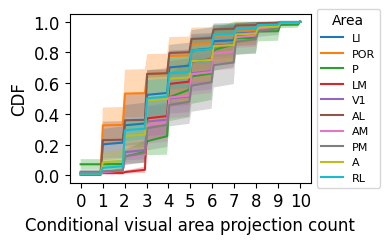

In [65]:
# Map visual area names to their labels using convert_dict
convert_dict = {
        "VISp": "V1",
        "VISpor": "POR",
        "VISli": "LI",
        "VISal": "AL",
        "VISl": "LM",
        "VISpl": "P",
        "VISpm": "PM",
        "VISrl": "RL",
        "VISam": "AM",
        "VISa": "A",
    }
mean_cdfs_mapped = {}
sem_cdfs_mapped = {}
for area, mean_cdf in mean_cdfs.items():
    new_label = convert_dict.get(area, area)  # Use the mapped name or fall back to the original
    mean_cdfs_mapped[new_label] = mean_cdf
    sem_cdfs_mapped[new_label] = sem_cdfs[area]

# Plot cumulative frequency distributions with SEM using mapped labels
plt.figure(figsize=(4, 2.5))
for area, mean_cdf in mean_cdfs_mapped.items():
    sem_cdf = sem_cdfs_mapped[area]
    plt.plot(common_points, mean_cdf, label=f'{area}')  # Use the mapped area label
    plt.fill_between(common_points, mean_cdf - sem_cdf, mean_cdf + sem_cdf, alpha=0.3)

plt.xlabel('Conditional visual area projection count', size=12)
plt.ylabel('CDF', size=12)

# Adjust x-axis ticks to be integers and display every 1
plt.xticks(np.arange(0, int(global_max) + 1, 1), size=12)
plt.yticks(size=12)
# Move legend outside the plot
plt.legend(title='Area', loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})  # Adjust font size with 'size'


# Adjust layout to make space for the legend
plt.tight_layout()

plt.show()


In [ ]:
key='homogenous_across_cubelet'

# Load Mouse Connectivity Cache and reference space
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
structure_tree = mcc.get_structure_tree()

# Initialize conditional frequency dictionary
cond_freq_dict = {}

# Define analysis names and areas of interest
visual_areas_group1 = ['VISli', 'VISpor', 'VISal']
visual_areas_group2 = ['VISp', 'VISl', 'VISam', 'VISpm', 'VISa', 'VISrl']

# Iterate over analysis keys
common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)

# Select visual areas in the cortex
common_cols_cortex = [
    col for col in common_columns if col == 'Contra' or 
    (col != 'Contra' and 315 in structure_tree.get_structures_by_acronym([col])[0]['structure_id_path'])
]
vis_adj = [vis for vis in visual_areas_group1 + visual_areas_group2 if vis in common_cols_cortex]

# Collect data for the two groups
group1_counts = []
group2_counts = []

for mouse in mice:
    for area in vis_adj:
        df = combined_dict[mouse][key][vis_adj]
        BC_cond = df[df[area] > 0].astype(bool).sum(axis=1)  # Collect counts, not means

        # Append counts to the appropriate group
        if area in visual_areas_group1:
            group1_counts.extend(BC_cond.values)
        elif area in visual_areas_group2:
            group2_counts.extend(BC_cond.values)

# Create a DataFrame for the two groups
comparison_df = pd.DataFrame({
    'Counts': group1_counts + group2_counts,
    'Group': ['Group 1'] * len(group1_counts) + ['Group 2'] * len(group2_counts)
})



In [ ]:
key = 'homogenous_across_cubelet'

# Load Mouse Connectivity Cache and reference space
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
structure_tree = mcc.get_structure_tree()

# Define visual areas of interest
visual_areas_group1 = ['VISli', 'VISpor', 'VISal']
visual_areas_group2 = ['VISp', 'VISl', 'VISam', 'VISpm', 'VISa', 'VISrl']

# Determine common columns in the data
common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)

# Select visual areas in the cortex
common_cols_cortex = [
    col for col in common_columns if col == 'Contra' or 
    (col != 'Contra' and 315 in structure_tree.get_structures_by_acronym([col])[0]['structure_id_path'])
]
vis_adj = [vis for vis in visual_areas_group1 + visual_areas_group2 if vis in common_cols_cortex]

# Initialize lists to collect mouse-level means for each group
group1_mouse_means = []
group2_mouse_means = []

# Collect group-level data across all areas for each mouse
for mouse in mice:
    group1_counts = []
    group2_counts = []
    for area in vis_adj:
        df = combined_dict[mouse][key][vis_adj]
        BC_cond = df[df[area] > 0].astype(bool).sum(axis=1)  # Projection count for this mouse and area
        
        # Collect projection counts for each group
        if area in visual_areas_group1:
            group1_counts.append(BC_cond.mean())  # Mean projection count for this area
        elif area in visual_areas_group2:
            group2_counts.append(BC_cond.mean())  # Mean projection count for this area

    # Calculate and store the mean projection count across all areas for each group
    if group1_counts:
        group1_mouse_means.append(np.mean(group1_counts))
    if group2_counts:
        group2_mouse_means.append(np.mean(group2_counts))

# Calculate group-level mean and SEM (variation across mice)
group1_mean = np.mean(group1_mouse_means) if group1_mouse_means else 0
group1_sem = sem(group1_mouse_means) if len(group1_mouse_means) > 1 else 0

group2_mean = np.mean(group2_mouse_means) if group2_mouse_means else 0
group2_sem = sem(group2_mouse_means) if len(group2_mouse_means) > 1 else 0

# Create a summary DataFrame for the group-level statistics
group_summary = pd.DataFrame({
    'Group': ['Group 1', 'Group 2'],
    'Mean Projection Count': [group1_mean, group2_mean],
    'SEM': [group1_sem, group2_sem]
})
print(group_summary)

In [96]:
group_summary

,Group,Mean Projection Count,SEM
0,Group 1,3.213744,0.473376
1,Group 2,4.387680,0.581814


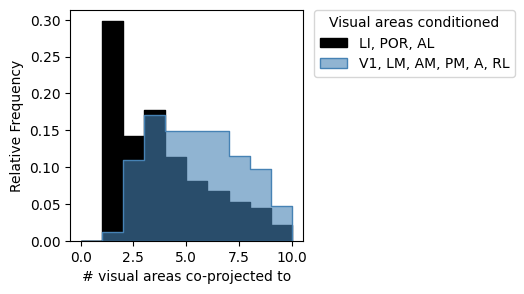

In [107]:
plt.figure(figsize=(3, 3))

# Explicitly set bins as integers to avoid gaps
max_count = comparison_df['Counts'].max()
bins = range(0, max_count + 2)  # Ensure bins cover all integers

# Plot histograms for each group separately
sb.histplot(
    data=comparison_df[comparison_df['Group'] == 'Group 1'],
    x="Counts",
    color="black",
    bins=bins,
    element="step",
    stat="density",  # Normalize to relative frequency
    alpha=1,
    label="LI, POR, AL"  # Manually assign label
)

sb.histplot(
    data=comparison_df[comparison_df['Group'] == 'Group 2'],
    x="Counts",
    color="steelblue",
    bins=bins,
    element="step",
    stat="density",  # Normalize to relative frequency
    alpha=0.6,
    label="V1, LM, AM, PM, A, RL"  # Manually assign label
)

# Add labels and title
plt.xlabel('# visual areas co-projected to')
plt.ylabel('Relative Frequency')

# Add a manual legend
plt.legend(title='Visual areas conditioned', loc='upper left',
    bbox_to_anchor=(1.05, 1),  # Position outside the plot to the right
    borderaxespad=0)
plt.tight_layout()
plt.show()


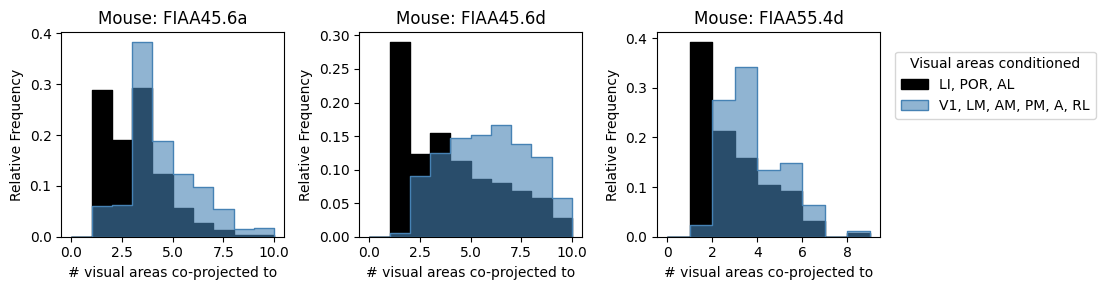

In [106]:

import math

# Define the number of subplots per row
num_mice = len(mice)
num_cols = 3
num_rows = math.ceil(num_mice / num_cols)

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

axes = axes.flatten()

# Area labels for the legend
group1_label = "LI, POR, AL"
group2_label = "V1, LM, AM, PM, A, RL"

# Loop through each mouse and plot its histogram in a subplot
for i, mouse in enumerate(mice):
    ax = axes[i]
    
    # Get data for the current mouse
    mouse_df = combined_dict[mouse][key][vis_adj]
    
    # Initialize lists for Group 1 and Group 2 counts
    group1_counts = []
    group2_counts = []
    
    # Collect counts for each group
    for area in vis_adj:
        BC_cond = mouse_df[mouse_df[area] > 0].astype(bool).sum(axis=1)
        if area in visual_areas_group1:
            group1_counts.extend(BC_cond.values)
        elif area in visual_areas_group2:
            group2_counts.extend(BC_cond.values)
    
    # Create a DataFrame for this mouse's data
    mouse_comparison_df = pd.DataFrame({
        'Counts': group1_counts + group2_counts,
        'Group': ['Group 1'] * len(group1_counts) + ['Group 2'] * len(group2_counts)
    })
    
    # Define bins for the histogram
    max_count = mouse_comparison_df['Counts'].max()
    bins = range(0, max_count + 2)  # Ensure bins cover all integers
    
    # Plot histograms for each group separately
    sb.histplot(
        data=mouse_comparison_df[mouse_comparison_df['Group'] == 'Group 1'],
        x="Counts",
        color="black",
        bins=bins,
        element="step",
        stat="density",  # Normalize to relative frequency
        alpha=1,
        label=group1_label,
        ax=ax
    )
    
    sb.histplot(
        data=mouse_comparison_df[mouse_comparison_df['Group'] == 'Group 2'],
        x="Counts",
        color="steelblue",
        bins=bins,
        element="step",
        stat="density",  # Normalize to relative frequency
        alpha=0.6,
        label=group2_label,
        ax=ax
    )
    
    # Add labels and title
    ax.set_xlabel('# visual areas co-projected to')
    ax.set_ylabel('Relative Frequency')
    ax.set_title(f"Mouse: {mouse}")

# Remove any unused subplots
for j in range(num_mice, len(axes)):
    fig.delaxes(axes[j])

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Visual areas conditioned",
    loc="center left",
    bbox_to_anchor=(1.0, 0.7),  # Position the legend outside the plotting area
    borderaxespad=0
)

# Adjust layout to make space for the legend
plt.tight_layout()
plt.show()


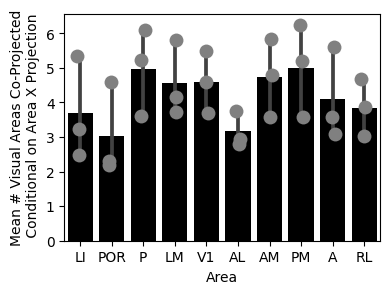

In [27]:
key='homogenous_across_cubelet'
to_look = cond_freq_dict[key]
to_look =fpf.convert_matrix_names(to_look)
df_long = to_look.reset_index().melt(id_vars='index', var_name='Area', value_name='BC_cond')
plt.figure(figsize=(4, 3))  

# Create the box plot
#sb.boxplot(x='Area', y='BC_cond', data=df_long, color='black', boxprops=dict(alpha=1))
sb.barplot(x='Area', y='BC_cond', data=df_long, color='black')
# Overlay the individual data points with jitter
sb.stripplot(x='Area', y='BC_cond', data=df_long, jitter=True, color='grey', size=10)
plt.ylabel('Mean # Visual Areas Co-Projected\n Conditional on Area X Projection')


# Show the plot
#plt.xticks(rotation=90)  # Rotate x-ticks if area names are long
plt.tight_layout()  # Adjust layout
plt.show()

In [60]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
layers = ['upper', 'lower']
mouse_layer_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    parameters = fpf.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
    for layer in layers:
        area_dict = {}
        barcodes_new = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
        barcodes_new = barcodes_new[
            (barcodes_new[[f for f in parameters['cortical_samples'] if f in barcodes_new.columns]].astype(bool).sum(axis=1) > 0) &
            (barcodes_new[[s for s in parameters['tectum_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0) &
            (barcodes_new[[s for s in parameters['thalamus_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0)
        ]
        area_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
       # missing_cols = set(all_mice[key].columns) - set(area_dict['area_is_main'].columns) #since there is some zero values for regions that are looked at
        #for col in missing_cols:
        #    area_dict['area_is_main'][col] = 0
        area_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, IT_only=True, shuffled=False, dummy_data=False)
        area_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, IT_only=True, shuffled=False)
        new_dict[f'{layer}_layer'] = area_dict
        # print(f"Creating barcodes for {layer} layer in {mouse}")
        # print(area_dict['homogenous_across_area'])
    
    mouse_layer_dict[mouse] = new_dict


In [61]:
def add_mouse_layer(df, mouse_label, layer_label):
    df['Mouse'] = mouse_label
    df['Layer'] = layer_label
    return df
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
key = 'homogenous_across_cubelet'
new_layer_dict = {}
for mouse in mice:
    mini_dict = {}
    for layer in layers:
        mini_dict[f'{layer}_layer'] = mouse_layer_dict[mouse][f'{layer}_layer'][key][visual_areas].astype(bool).astype(int)
        mini_dict[f'{layer}_layer'] = add_mouse_layer(mini_dict[f'{layer}_layer'], mouse, layer)
    concatenated_df = pd.concat(mini_dict.values(), axis=0, ignore_index=False)
    new_layer_dict[mouse] = concatenated_df
combined_df = pd.concat(new_layer_dict.values(), axis=0, ignore_index=False)
combined_df = combined_df.dropna(axis=1, how='any')

In [ ]:

results = {}

# Reshape the data
df = combined_df.melt(id_vars=['Mouse', 'Layer'], var_name='Area', value_name='Projection')

pval_df = pd.DataFrame(index=visual_areas, columns=['p_value', 'OR'])


for area in visual_areas:
    # Filter data for the current area
    df_area = df[df['Area'] == area]
    
    # Fit the logistic regression model
    model = smf.logit('Projection ~ Layer + Mouse', data=df_area).fit(disp=False)
    
    # Extract model summary
    results = model.summary2().tables[1]
    
    # Extract p-value and odds ratio for the 'Layer' effect
    pval_df.loc[area, 'p_value'] = results.loc['Layer[T.upper]', 'P>|z|']
    pval_df.loc[area, 'OR'] = np.exp(results.loc['Layer[T.upper]', 'Coef.'])



In [ ]:
pval_df['p_value_corrected'] = pval_df['p_value']*len(pval_df)
summary_df = pd.DataFrame(index = mice, columns = visual_areas)
for mouse in mice:
    dff = new_layer_dict[mouse]
    for area in visual_areas:
        freq_upper = dff[dff['Layer']=='upper'][area].mean()
        freq_lower = dff[dff['Layer']=='lower'][area].mean()
        summary_df.loc[mouse, area] = freq_upper/freq_lower
visual_areas = summary_df.columns

,VISli,VISpor,VISpl,VISl,VISp,VISal,VISam,VISpm,VISa,VISrl
FIAA45.6a,1.392857,1.268657,0.357143,1.122449,1.041667,1.075269,1.833333,0.909091,2.6,2.840909
FIAA45.6d,1.288739,1.479859,1.40873,1.014286,1.005617,0.759298,1.544136,1.254026,1.364039,1.07337
FIAA55.4d,2.842697,2.033708,1.483146,1.575843,1.651685,1.537408,1.884831,2.274157,1.167291,1.142423


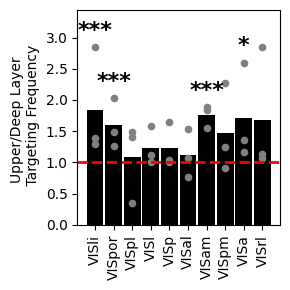

In [121]:
plt.figure(figsize=(3, 3))  # Adjusted figure size for better layout

# Calculate the mean ratio for each area across mice
area_means = summary_df.mean(axis=0)

# Calculate the maximum value across the data for setting y-limit and asterisk height
max_value = summary_df.max().max()

# Bar plot for mean ratios per area
sb.barplot(x=visual_areas, y=area_means, color='black', ci=None, width=0.9, zorder=1)

# Overlay individual mouse data points for each area
for i, area in enumerate(visual_areas):
    for mouse in summary_df.index:
        plt.scatter(
            i,  # x-coordinate (aligned with bar position)
            summary_df.loc[mouse, area],  # y-coordinate (value for this mouse and area)
            color='grey', s=20, zorder=2
        )

# Add asterisks for significant areas
#asterisk_height = max_value + 0.3  # Set consistent height for asterisks above the highest data point
for i, area in enumerate(visual_areas):
    asterisk_height = summary_df[area].max() + 0.1  # Set consistent height for asterisks above the highest data point
    p_value = pval_df.loc[area, 'p_value_corrected']  # Get the p-value for the area
    if p_value <= 0.001:
        asterisk = '***'
    elif p_value <= 0.01:
        asterisk = '**'
    elif p_value <= 0.05:
        asterisk = '*'
    else:
        asterisk = None  # No asterisk if p > 0.05
    
    if asterisk:  # Add asterisk if significance is present
        plt.text(
            i,  # x-coordinate (aligned with bar center)
            asterisk_height,  # y-coordinate (same for all asterisks)
            asterisk,  # Asterisk(s) for significance
            ha='center', va='bottom', fontsize=16, color='black', weight='bold'
        )

# Add a horizontal line at y=1
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Set y-axis limit to ensure asterisks are visible
plt.ylim(0, asterisk_height + 0.5)  # Extend y-limit slightly above asterisk height

# Add labels and title
plt.ylabel('Upper/Deep Layer \n Targeting Frequency')
#plt.xlabel('Visual Area')
#plt.title('Upper/Deep Layer Neuron Frequency Ratios by Visual Area')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [107]:
pval_df

,p_value,OR,p_value_corrected
VISli,0.000007,1.617214,0.000075
VISpor,0.0,1.829173,0.0
VISpl,0.147952,1.344754,1.479517
VISl,0.417499,1.101493,4.174992
VISp,0.281499,1.140253,2.814994
VISal,0.006732,0.768348,0.067317
VISam,0.000013,1.788299,0.000131
VISpm,0.008185,1.499626,0.081849
VISa,0.001134,1.486862,0.011338
VISrl,0.030468,1.292097,0.304678


In [80]:
summary_df = pd.DataFrame(index = mice, columns = visual_areas)
for mouse in mice:
    dff = new_layer_dict[mouse]
    for area in visual_areas:
        freq_upper = dff[dff['Layer']=='upper'][area].mean()
        freq_lower = dff[dff['Layer']=='lower'][area].mean()
        summary_df.loc[mouse, area] = freq_upper/freq_lower

<AxesSubplot:>

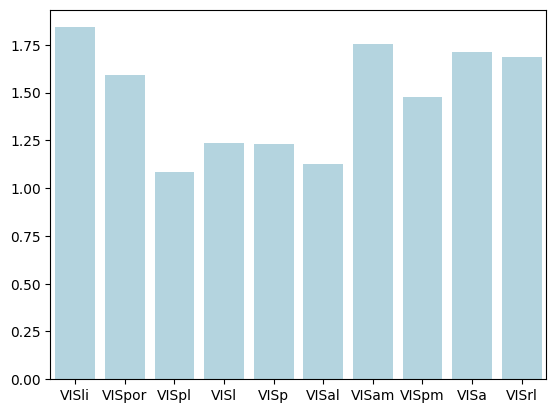

In [84]:
sb.barplot(data=summary_df, color='lightblue', ci=None)

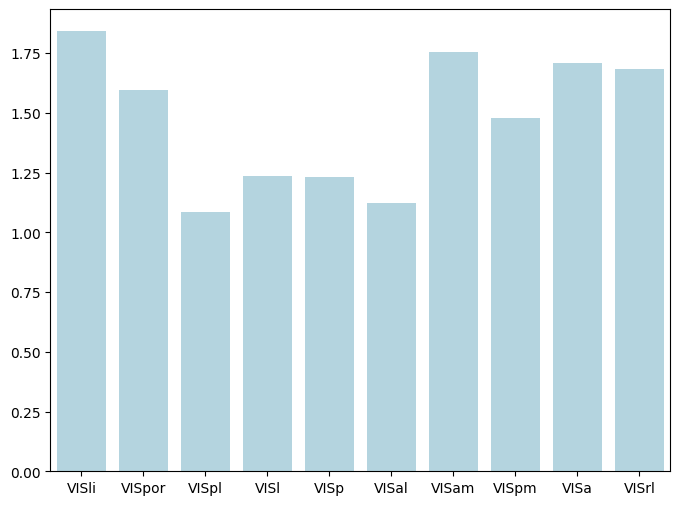

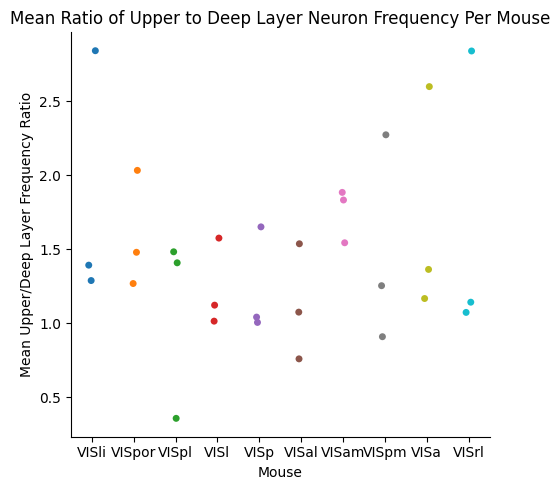

In [86]:
plt.figure(figsize=(8, 6))

# Bar plot of the mean ratios
sb.barplot(data=summary_df, color='lightblue', ci=None)

sb.catplot(data=summary_df)

# Add labels and title
plt.ylabel('Mean Upper/Deep Layer Frequency Ratio')
plt.xlabel('Mouse')
plt.title('Mean Ratio of Upper to Deep Layer Neuron Frequency Per Mouse')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
pval_df = pd.DataFrame(index=visual_areas, columns=visual_areas)
OR_df = pd.DataFrame(index=visual_areas, columns=visual_areas)

for area in visual_areas:
    # Filter data for the current area
    df_area = df[df['Area'] == area]
    
    # Fit the logistic regression model
    model = smf.logit('Projection ~ Layer + Mouse', data=df_area).fit(disp=False)
    
    # Extract model summary
    results = model.summary2().tables[1]
    
    # Extract p-value and odds ratio for the 'Layer' effect
    pval_df.loc[area, 'Layer'] = results.loc['Layer', 'P>|z|']
    OR_df.loc[area, 'Layer'] = np.exp(results.loc['Layer', 'Coef.'])

df_long = combined_df.melt(id_vars=['Mouse', 'Layer'], var_name='Area', value_name='Projection')
df_long['Layer'] = df_long['Layer'].apply(lambda x: 1 if x == 'upper' else 0)

In [65]:
results

{'VISli': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e6d336970>,
 'VISpor': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e6dd200d0>,
 'VISpl': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e6d4308e0>,
 'VISl': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e79116970>,
 'VISp': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e7913b340>,
 'VISal': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e79125700>,
 'VISam': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e791236d0>,
 'VISpm': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e79095730>,
 'VISa': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e79090790>,
 'VISrl': <statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x7f8e790a17f0>}